# Tarea 1 MCMC Metropolis

In [34]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt

import seaborn as sns 

In [2]:
from scipy.stats import distributions
dnorm = distributions.norm.logpdf

In [3]:
data=np.load('fit_exercise.npy')
yerror=data[2]

In [4]:
def calc_posterior(a, b, t, y=data[1], x=data[0]):     #función para encontrar el postirior   
    #usando un Prior Gausiano Plano tenemos que Prior=1, entonces, como Ln(1)=0 tendremos que el postirior tiene solo 
    #la contribución del likelihood
    logp=0
    mu = a + b*x                          #calculamos el valore del modelo segun los datos (modelo lineal)
    logp += sum(dnorm(y, mu, t**-2))      # sumatoria del likelihood 
    
    return logp

In [5]:
def metropolis(n_iterations, initial_values, prop_var):

    n_params = len(initial_values)    #se usa el tamaño del arreglo de valores iniciales         
    prop_sd = [prop_var]*n_params     #se crea un vector de tres entradas donde cada entrada tiene el valor prop_var
    evolution = np.empty((n_iterations+1, n_params))  #crea un arreglo con n_params columnas y n_iterations+1 filas 
                                                      #en esta matriz se guardará la evolución de los parametros a, b y sigma
    evolution[0] = initial_values     #Llena la primer fila con los valores iniciales para tomarlos como base de la evolución
    current_log_prob = calc_posterior(*evolution[0])  #llamado a la función con entradas como vector que corresponden a los 
                                                      #valores a, b y sigma
    accepted = [0]*n_params           #se crea un vector de n_param entradas donde cada entrada tiene el valor 0
    
    rnorm = np.random.normal
    runif = np.random.rand

    for i in range(n_iterations):       #en este primer for se llenaran todas las filas de evolution 
        current_params = evolution[i]   #paramatros iniciales para los valores que se calcularan 
        for j in range(n_params):       #en este for se llenan las colunas correspondientes a las i-esimas filas 
            p = evolution[i].copy()     #Realiza una copia de la fila i-esima para calcular nuevamente el postirior y comparar
        
            if j==2:
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
                
            p[j] = theta                             #se reescribe p con los calculos anteriores
            proposed_log_prob = calc_posterior(*p)   #se calcula el postitior con los valores de p propuestos
            alpha = proposed_log_prob - current_log_prob #se calcula el ratio de los postiriors y como es una divición
                                                         #se pone como una resta por las propiedades de logaritmos
            u = runif()             #numero aleatorio con una distribución uniforme entre el 0 y 1
            if np.log(u) < alpha:   #si el número es menor que el ratio los parametros son aceptados y seran ahora iniciales
                evolution[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:                    #si no cumple se rechaza y se toman los valores anteriores iniciales itera nuevamente
                evolution[i+1,j] = evolution[i,j]
                
    return evolution

In [6]:
n_iterations=3000
initial_values=[1,1,.5]
evolution = metropolis(n_iterations,initial_values,.05)

array([ 5.09045245, -1.06198814,  0.99691729])

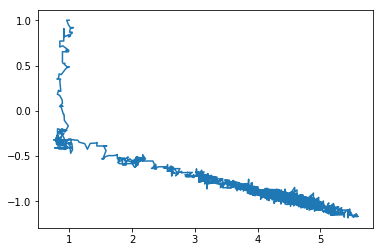

In [7]:
plt.plot(evolution[:,0],evolution[:,1])
evolution[-1]

In [8]:
#graficando los datos con la solución obtenida
ysol=np.zeros(len(data[0]))
for i in range (len(data[0])):
    ysol[i]=evolution[-1,0]+evolution[-1,1]*data[0,i]

hasta aquí hemos obtenido un valor en el cual el metrodo MCMC metropoli tiene como solución los parametros a, b de la recta. Ahora se compararan con los obtenido con el MLM (maximum likelihood method) y se graficaran las rectas

## Comparando con Maximum Likelihood Method

Supongamos que se tienen n mediciones ($x_1, y_1\pm \sigma_1$; $x_2, y_2\pm \sigma_2$; $x_n, y_n\pm \sigma_n$) si se conoce la función de distribución entonces se conoce una relación funcional de $y=f(x,\alpha, \beta, \gamma, ...)$ donde $\alpha, \beta, \gamma, ...$ son parametros 

Likelihood Function es $$L=\prod_{i=1}^{n} f(x_i,\alpha, \beta, ...)$$

Usando un likelihood gausiano para una linea recta


$$L=\prod_{i=1}^{n} \frac{1}{\sigma_i\sqrt{2\pi}}exp({-\frac{(y_i- \lambda (x_i , \theta ))^2}{2\sigma_i^2}})$$
$$L=\prod_{i=1}^{n} \frac{1}{\sigma_i\sqrt{2\pi}}exp({-\frac{(y_i-\alpha-\beta x_i)^2}{2\sigma_i^2}})$$

$$ ln ({L}(x_i,y_i|\vec{\theta}))= \sum_{i}ln(\frac{1}{\sigma_i\sqrt{2\pi}}) -\frac{(y_i-\alpha-\beta x_i)^2 }{2\sigma_i^2}$$


Para maximizar la función obtenemos 

$$\frac{\partial}{\partial\alpha}ln(L)=\sum_{i}\frac{y_i-\alpha -\beta x_1}{\sigma_i^2}=0$$

$$\frac{\partial}{\partial\beta}ln(L)=\sum_{i}\frac{(y_i-\alpha -\beta x_1)x_i}{\sigma_i^2}=0$$

o bien

$$\sum_{i}\frac{y_i}{\sigma_i^2}=\alpha\sum_{i}\frac{1}{\sigma_i^2}+\beta\sum_{i}\frac{x_i}{\sigma_i^2}$$

$$\sum_{i}\frac{y_ix_i}{\sigma_i^2}=\alpha\sum_{i}\frac{x_i}{\sigma_i^2}+\beta\sum_{i}\frac{x_i^2}{\sigma_i^2}$$

El sistema a resolver es de la forma
$$\begin{pmatrix}
\sum_{i}\frac{y_i}{\sigma_i^2}\\
\sum_{i}\frac{y_ix_i}{\sigma_i^2}\\
\end{pmatrix}
\begin{pmatrix}
\sum_{i}\frac{1}{\sigma_i^2} & \sum_{i}\frac{x_i}{\sigma_i^2} \\
\sum_{i}\frac{x_i}{\sigma_i^2} & \sum_{i}\frac{x_i^2}{\sigma_i^2} \\
\end{pmatrix}=
\begin{pmatrix}
\alpha\\
\beta\\
\end{pmatrix}
$$

de los datos sabemos que A[0]-> x; A[1]->y, A[2]->error, a->b0, b->b1

In [13]:
X=data[0,]
Y=data[1,]
Sigma=data[2,]
Sigma_sqrt=Sigma
Sigma_sq=Sigma**2   

In [14]:
S=[np.sum(Y/Sigma_sq),np.sum((Y*X)/Sigma_sq)]
M=[(np.sum(1/Sigma_sq),np.sum(X/Sigma_sq)),(np.sum(X/Sigma_sq),np.sum((X**2)/Sigma_sq))]
M_inv = np.linalg.inv(M)
solucion=M_inv @ S
y=np.zeros(len(X))

In [15]:
#usando los valores de X tenemos
for i in range (len(X)):
    y[i]=solucion[0]+solucion[1]*X[i]
solucion

array([ 5.44055525, -1.1040757 ])

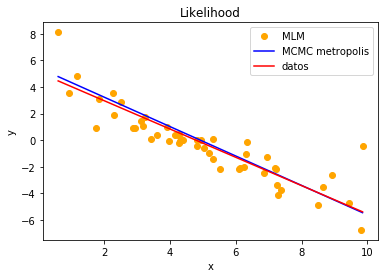

In [28]:
plt.plot(data[0],data[1], 'o', color='orange')
plt.plot(X,y, color='blue')
plt.plot(data[0],ysol, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Likelihood')
plt.legend(('MLM', 'MCMC metropolis', 'datos'), loc='upper right')
plt.show()

![](1.jpg)